## importing data set and loading necessary libraries

In [5]:
import pandas as pd
import numpy as np


## plotting within notebook

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

import warnings
warnings.filterwarnings('ignore')


## setting figure size

In [7]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

## reading the file

In [8]:
df = pd.read_csv('SSE_final.csv')

In [9]:
df.head()

,Date,Open,High,Low,Close,Volume,Momentum
0,02-01-2004,997.00,1021.57,993.89,1011.35,8064652,5.742759e+09
1,05-01-2004,1008.28,1060.90,1008.28,1060.80,14468180,1.070646e+10
2,06-01-2004,1059.14,1086.69,1059.09,1075.66,16991334,1.241700e+10
3,07-01-2004,1075.56,1095.84,1070.98,1086.30,13729419,1.035253e+10
4,08-01-2004,1087.68,1108.29,1082.51,1102.66,10780427,8.188927e+09


In [6]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%d-%m-%Y')
df.index = df['Date']
df.index=df['Date']

In [10]:
from sklearn import preprocessing


from sklearn.preprocessing import MinMaxScaler


# create scaler
scaler = MinMaxScaler()


df[['Open','High','Close','Low','Volume','Momentum']] = scaler.fit_transform(df[['Open','High','Close','Low','Volume','Momentum']])



In [11]:
df.head()

,Date,Open,High,Low,Close,Volume,Momentum
0,02-01-2004,0.073937,0.077395,0.075189,0.077125,0.017382,0.011482
1,05-01-2004,0.076738,0.087067,0.078791,0.089391,0.034416,0.023103
2,06-01-2004,0.089369,0.093410,0.091511,0.093077,0.041128,0.027107
3,07-01-2004,0.093446,0.095660,0.094487,0.095716,0.032451,0.022274
4,08-01-2004,0.096456,0.098722,0.097373,0.099774,0.024606,0.017209


In [12]:
df.index=df['Date']


## EDA

C:\Users\Work\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


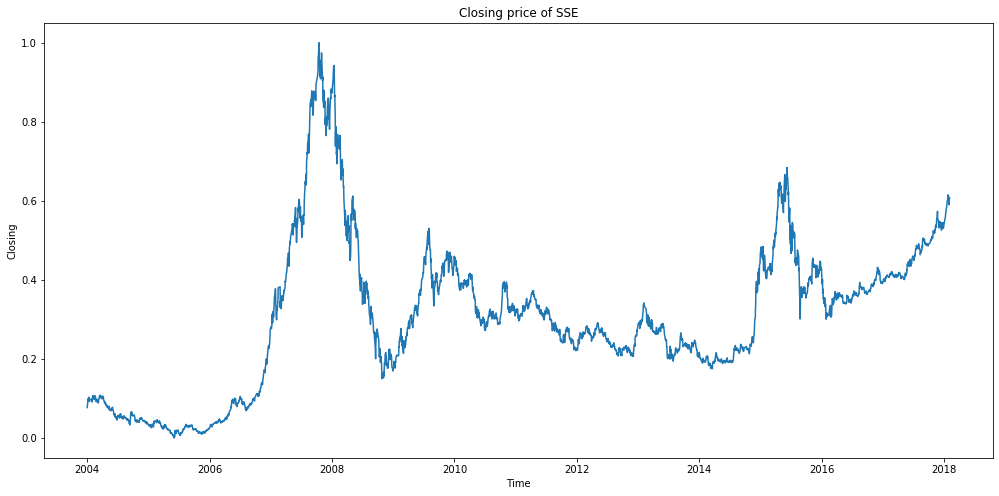

In [10]:
plt.figure(figsize=(17,8))
plt.plot(df.Close)
plt.title('Closing price of SSE')
plt.ylabel('Closing')
plt.xlabel('Time')
plt.grid(False)
plt.show()

In [ ]:
## Clearly, you see that this is not a stationary process, and it is hard to tell if there is some kind of seasonality.

In [ ]:
##Let’s use the moving average model to smooth our time series. For that, we will use a helper function that will run the moving average model on a specified time window and it will plot the result smoothed curve:

In [2]:
def plot_moving_average(series, window, plot_intervals = False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean,'g',label = 'Rolling mean trend')
    
    #plot confidence intervals for smoothed values
    
if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bound = rolling_mean - (mae + scale * deviation)
    upper_bound = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bound, 'r--')
    plt.plot(lower_bound, 'r--')
        
    plt.plot(series[window:], label = 'Actual values')
    plt.legend(loc = 'best')
    plt.grid(True)

NameError: name 'plot_intervals' is not defined

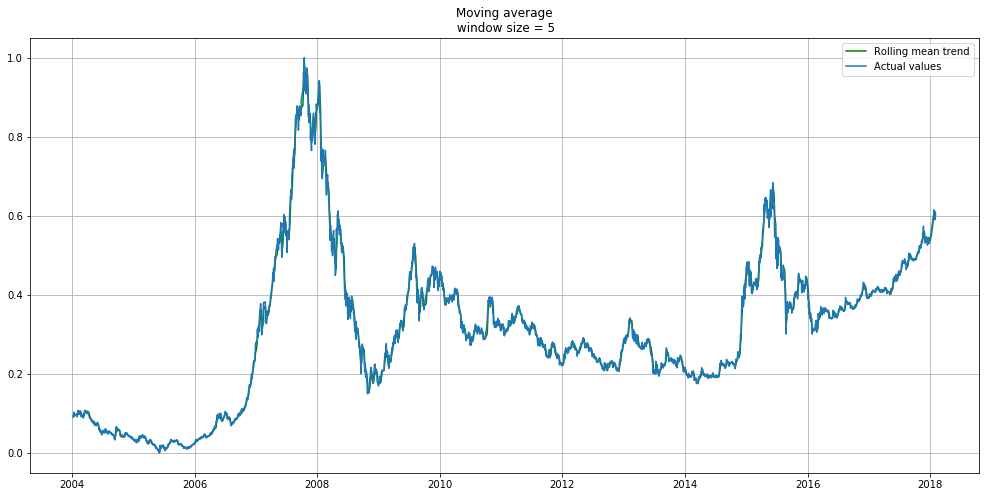

In [12]:
#smooth by the previous 5 days (by week)
plot_moving_average(df.Close,5)


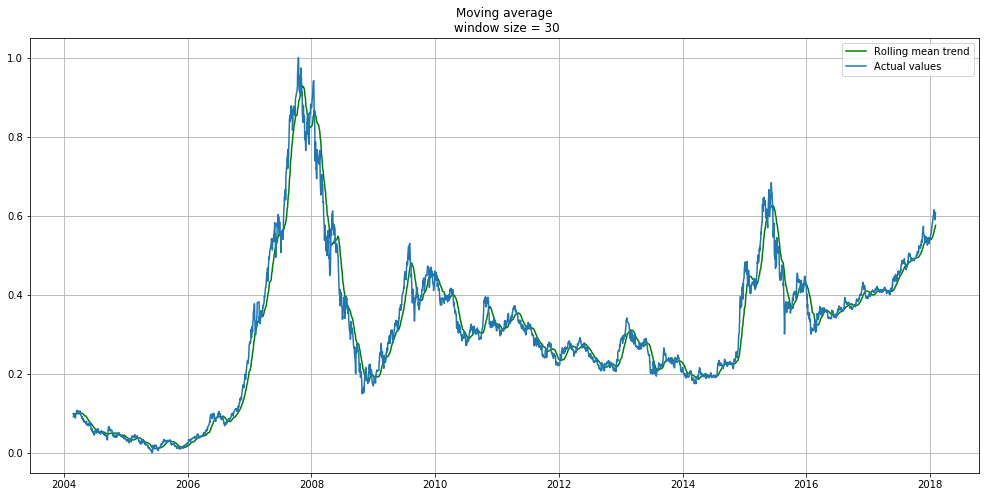

In [13]:
#smooth by the previous month (30 days)
plot_moving_average(df.Close, 30)


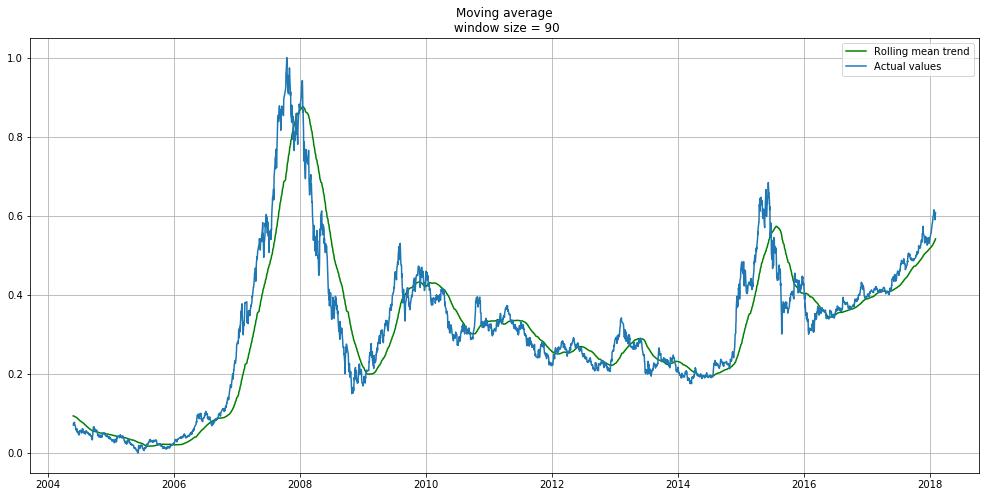

In [15]:
plot_moving_average(df.Close, 90)

In [ ]:
##Trends are easier to spot now. Notice how the 30-day and 90-day trend show a UPWARD curve at the end. This might mean that the stock is likely to go up in the following days.

In [19]:
def exponential_smoothing(series, alpha):
    result = [series[0]] #first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n]+(1- alpha)*result[n-1])
    return result
def plot_exponential_smoothing(series,alphas):
    
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label = 'Alpha {}'.format(alpha))
    plt.plot(series.values,"c",label ="Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential smoothing")
    plt.grid(True);
    

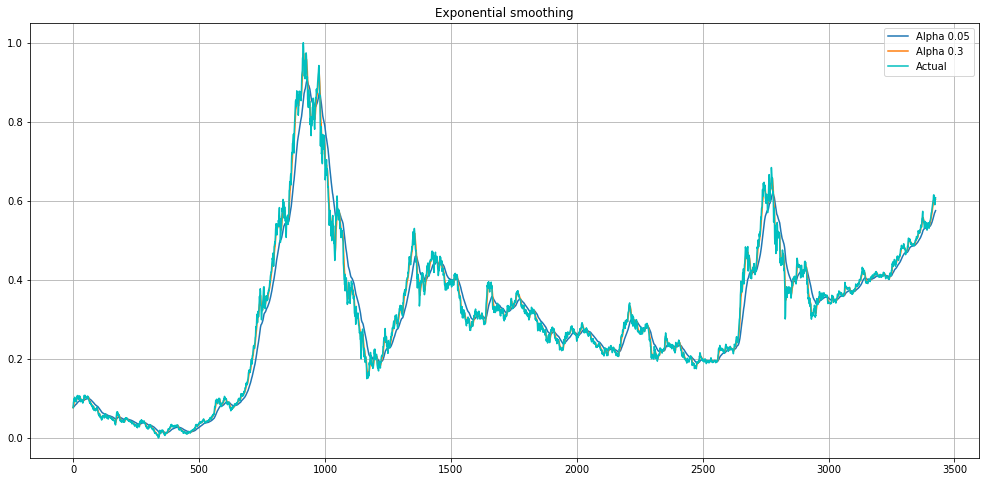

In [20]:
plot_exponential_smoothing(df.Close,[0.05,0.3])

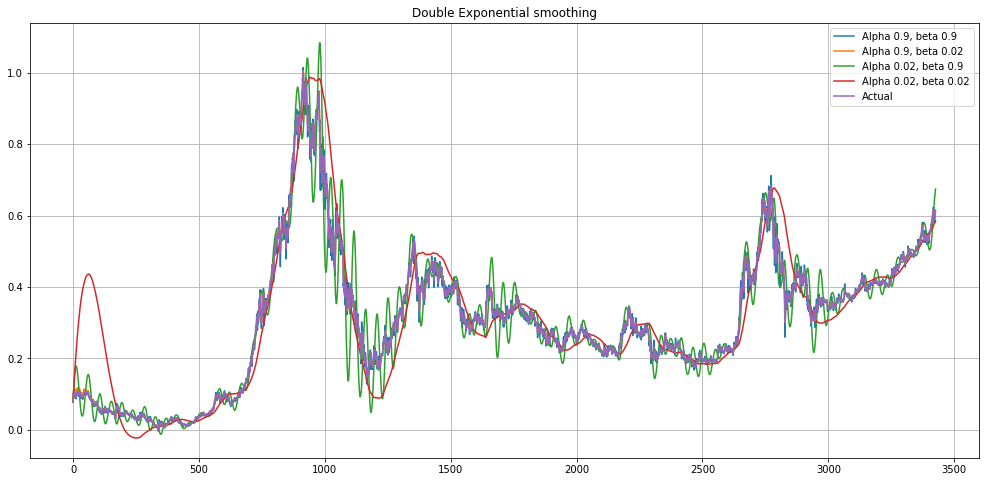

In [23]:
def double_exponential_smoothing(series, alpha, beta):
    
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level,trend = series[0],series[1] -series[0]
        if n>= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha ) * (level + trend)
        trend = beta * (level - last_level) + (1- beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    
    plt.figure(figsize=(17,8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label = "Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc = "best")
    plt.axis('tight')
    plt.title("Double Exponential smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(df.Close, alphas = [0.9,0.02], betas = [0.9,0.02])

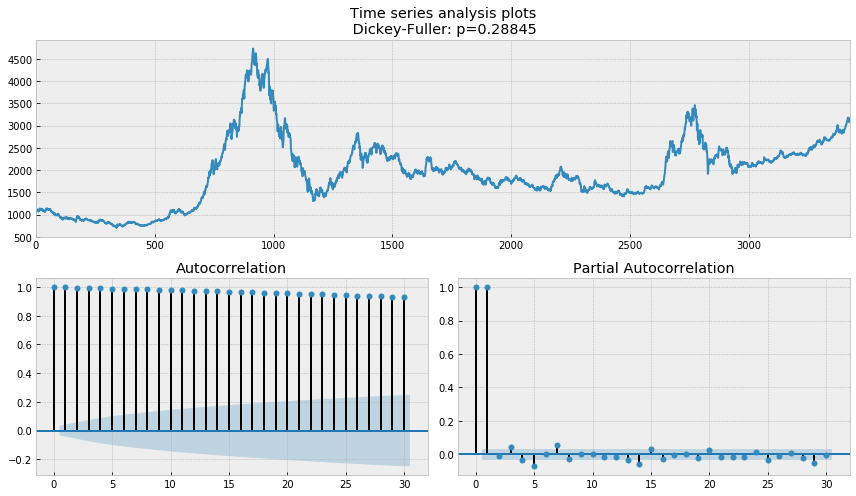

In [12]:
def tsplot(y, lags = None, figsize =(12,7), syle = 'bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    
    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0),colspan = 2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax = ts_ax)
        p_value = smt.stattools.adfuller(y)[1]
        ts_ax.set_title('Time series analysis plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags = lags,ax=acf_ax)
        smt.graphics.plot_pacf(y, lags = lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(df.Close, lags =30)

## By the Dickey-Fuller test, the time series is unsurprisingly non-stationary. Also, looking at the autocorrelation plot, we see that it is very high, and it seems that there is no clear seasonality.

## Therefore, to get rid of the high autocorrelation and to make the process stationary, let’s take the first difference. We simply the time series from itself with a lag of one day:

In [4]:
df_diff =  df.Close - df.Close.shift(1)
tsplot(df_diff[1:], lags = 30)

NameError: name 'df' is not defined

## our series is now stationary and we can start modelling

## SARIMA

In [14]:
#set initial values and some bounds

ps = range(0,5)
d = 1
qs = range(0,5)
Ps = range(0,5)

D = 1
Qs = range(0,5)

s = 5

#create a list with all possible combinations of parameteres
parameters = product(ps,qs,Ps,Qs)

parameters_list =  list(parameters)

len(parameters_list)

625

## we have 625 different combinations

In [19]:
def optimize_SARIMA(parameters_list, d, D , s):
    
    results = []
    
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(df.Close, order = (param[0], d, param[1]),
                                               seasonal_order = (param[2], D, param[3],s)).fit(disp = -1)
        except:
            continue
            
        aic = model.aic
        
        #save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param,model.aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters','aic']
    #sort in ascending order, lower AIC is better
    result_table =  result_table.sort_values(by = 'aic',ascending = True).reset_index(drop = True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

In [21]:
#set parameters that give the lowest AIC(Akaike Information Criteria)

p,q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.Close, order = (p,d,q),
                                     seasonal_order = (P, D, Q, s)).fit(disp = -1)

print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Close   No. Observations:                 3426
Model:             SARIMAX(3, 1, 4)x(0, 1, 4, 5)   Log Likelihood              -17497.151
Date:                           Fri, 18 Oct 2019   AIC                          35018.303
Time:                                   14:37:54   BIC                          35091.951
Sample:                                        0   HQIC                         35044.618
                                          - 3426                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1576      1.008      0.156      0.876      -1.817       2.133
ar.L2         -0.9530      0.147     -6.474

# Moving Average

In [25]:
df_diff.describe()

count    3425.000000
mean        0.624318
std        40.551621
min      -296.700000
25%       -12.440000
50%         0.490000
75%        15.050000
max       296.080000
Name: Close, dtype: float64

In [3]:
#creating dataframe with date and the target variable
data = df_diff.sort_index(ascending=True,axis=0)

new_data=pd.DataFrame(index=range(0,len(df)),columns = ['Close'])

for i in range(0,len(data)):
    
    new_data['Close'][i] = data['Close'][i]

NameError: name 'df_diff' is not defined

In [12]:
#spiltting into train and validation
train = new_data[:2100]
valid = new_data[2100:]

In [13]:
train.head()

,Date,Close
0,2004-01-02 00:00:00,0.0771246
1,2004-01-05 00:00:00,0.0893908
2,2004-01-06 00:00:00,0.0930768
3,2004-01-07 00:00:00,0.0957161
4,2004-01-08 00:00:00,0.0997743


In [14]:
new_data.shape

(3426, 2)

In [15]:
train.shape

(2100, 2)

In [16]:
valid.shape


(1326, 2)

In [17]:
train['Date'].min(),train['Date'].max(),valid['Date'].min(),valid['Date'].max()

(Timestamp('2004-01-02 00:00:00'),
 Timestamp('2012-08-23 00:00:00'),
 Timestamp('2012-08-24 00:00:00'),
 Timestamp('2018-02-02 00:00:00'))

In [18]:
#make predictions
preds = []
for i in range(0,1326):
    a = train['Close'][len(train)-1326+i:].sum()+sum(preds)
    b = a/1326
    preds.append(b)

In [19]:
#calculate rmse
rms = np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
rms

0.1306121136623995

C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


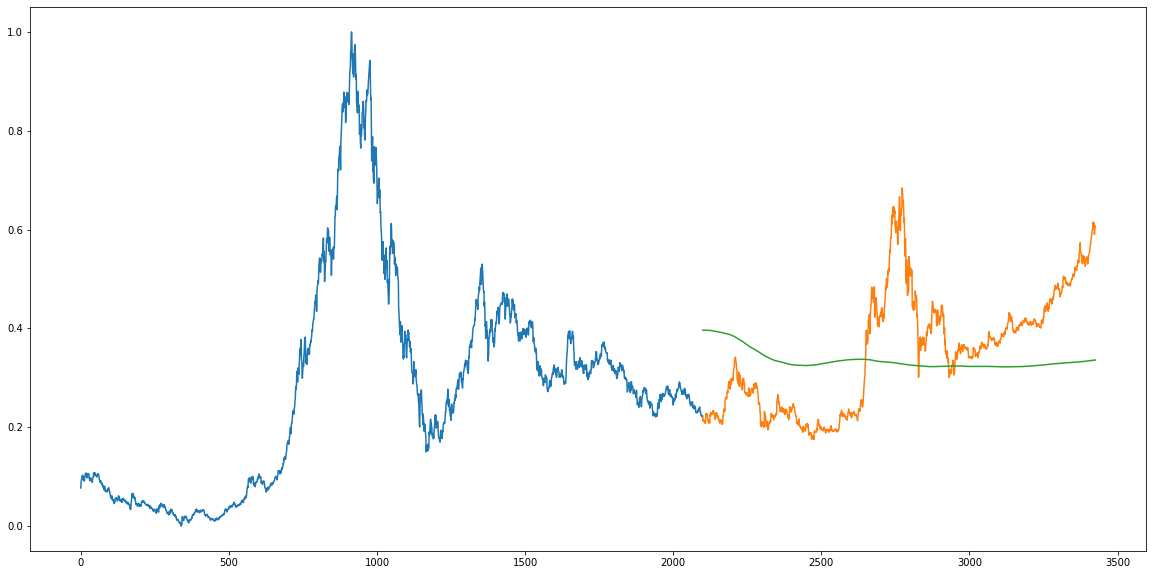

In [20]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])

# Linear Regression

### We will first sort the dataset in ascending order and then create a separate dataset so that any new feature created does not affect the original data.

In [21]:

df_diff.index = df_diff['Date']

#sorting
data = df_diff.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
    

In [22]:
#create features
from fastai.tabular import  add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

In [23]:
new_data['mon_fri'] = 0
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        new_data['mon_fri'][i] = 1
    else:
        new_data['mon_fri'][i] = 0

C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Splitting into test and train

In [24]:
#split into train and validation
train = new_data[:3100]
valid = new_data[3100:]

x_train = train.drop('Close', axis=1)
y_train = train['Close']
x_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Results

In [25]:
#make predictions and find the rmse
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

0.07850208963443417

C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


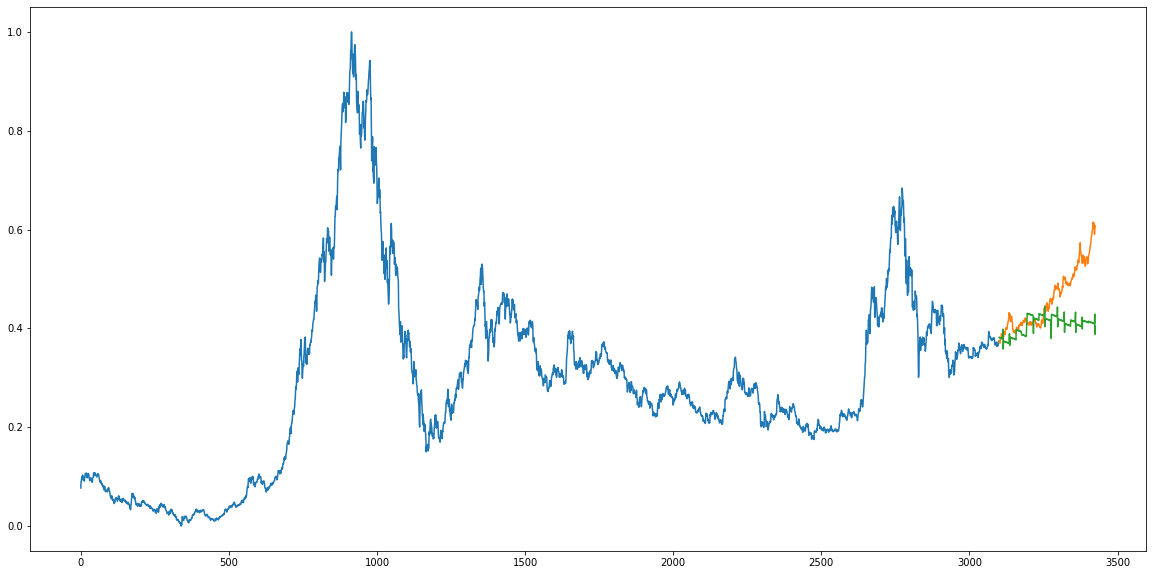

In [26]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds

valid.index = new_data[3100:].index
train.index = new_data[:3100].index

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])


## k-Nearest Neighbours

In [27]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [28]:
#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)


In [29]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

0.11650767578506063

C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


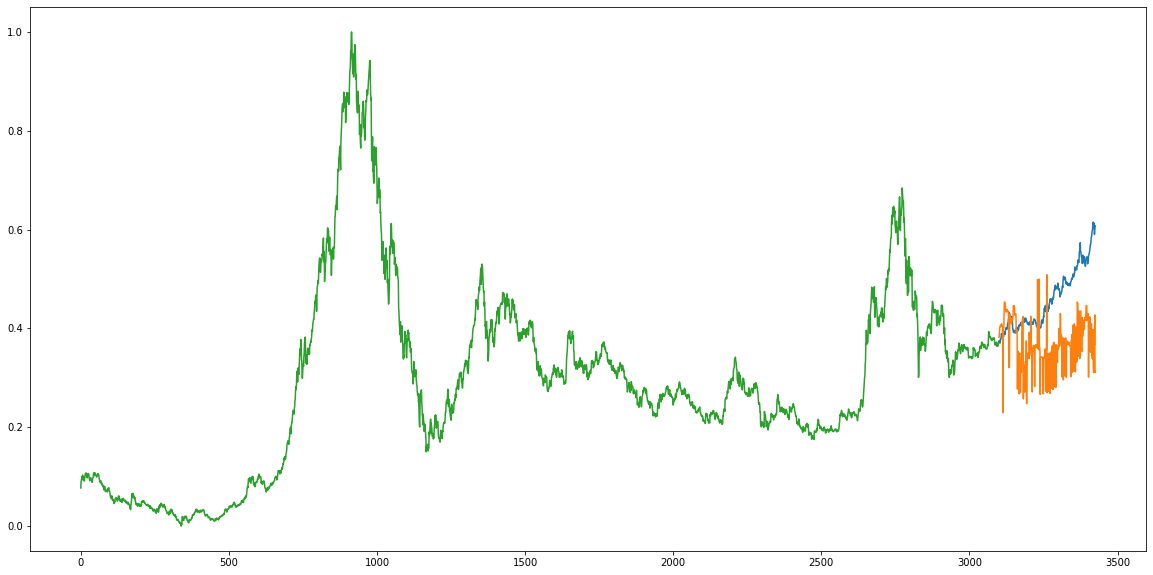

In [30]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])


# # Auto ARIMA

In [31]:
from pmdarima.arima import auto_arima

data = df_diff.sort_index(ascending=True, axis=0)

train = data[:3100]
valid = data[3100:]

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=326)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-19315.719, BIC=-19285.545, Fit time=16.130 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=-17392.049, BIC=-17379.980, Fit time=0.625 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-18267.478, BIC=-18243.338, Fit time=3.352 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-18901.179, BIC=-18877.039, Fit time=4.047 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-19307.727, BIC=-19271.517, Fit time=21.547 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=-17391.615, BIC=-17367.475, Fit time=0.975 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-19120.656, BIC=-19084.447, Fit time=28.302 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-19296.460, BIC=-19254.215, Fit time=42.730 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-19250.505, BIC=-19214.295, Fit time=18

In [32]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

0.12117765257053308

C:\Users\Work\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


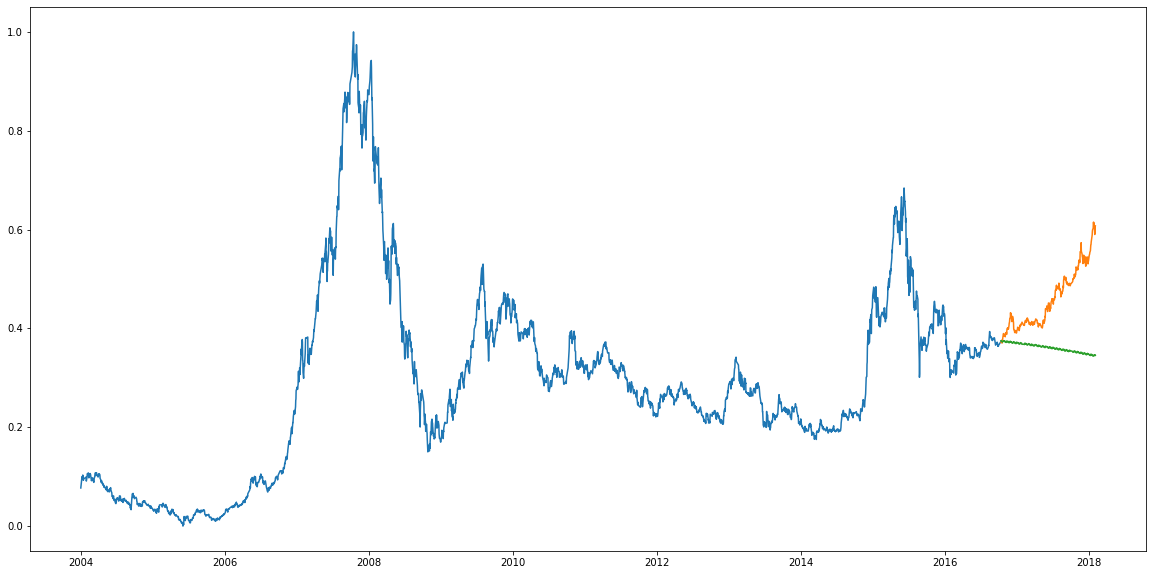

In [33]:
#plot
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

# Prophet

In [34]:
#importing prophet
from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [35]:
#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:3100]
valid = new_data[3100:]


In [36]:
#fit the model
model = Prophet()
model.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\Work\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [37]:
#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

In [38]:
#rmse
forecast_valid = forecast['yhat'][3100:]
rms=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

0.05952805416893227

C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


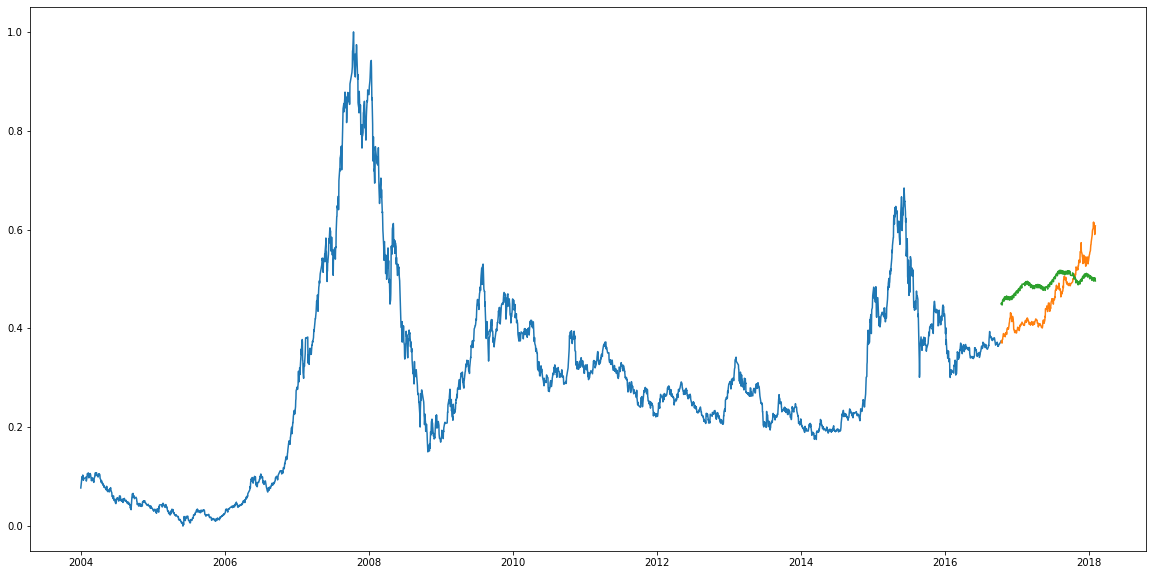

In [39]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

# Long Short Term Memory (LSTM)

In [40]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


Using TensorFlow backend.


In [41]:
#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

In [42]:
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [43]:
#creating train and test sets
dataset = new_data.values

train = dataset[0:3100,:]
valid = dataset[3100:,:]

In [44]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [45]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [47]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/100
 - 10s - loss: 0.0060
Epoch 2/100
 - 8s - loss: 6.7739e-04
Epoch 3/100
 - 8s - loss: 6.2512e-04
Epoch 4/100
 - 8s - loss: 5.1102e-04
Epoch 5/100
 - 8s - loss: 4.7710e-04
Epoch 6/100
 - 8s - loss: 4.1668e-04
Epoch 7/100
 - 8s - loss: 4.1843e-04
Epoch 8/100
 - 8s - loss: 4.0963e-04
Epoch 9/100
 - 8s - loss: 3.4222e-04
Epoch 10/100
 - 8s - loss: 3.2154e-04
Epoch 11/100
 - 8s - loss: 3.0168e-04
Epoch 12/100
 - 8s - loss: 2.8020e-04
Epoch 13/100
 - 8s - loss: 2.9788e-04
Epoch 14/100
 - 8s - loss: 2.9104e-04
Epoch 15/100
 - 8s - loss: 2.3989e-04
Epoch 16/100
 - 9s - loss: 2.2225e-04
Epoch 17/100
 - 8s - loss: 2.3279e-04
Epoch 18/100
 - 8s - loss: 2.0595e-04
Epoch 19/100
 - 8s - loss: 2.3260e-04
Epoch 20/100
 - 8s - loss: 1.9542e-04
Epoch 21/100
 - 8s - loss: 1.9570e-04
Epoch 22/100
 - 8s - loss: 2.0862e-04
Epoch 23/100
 - 8s - loss: 1.8525e-04
Epoch 24/100
 - 8s - loss: 1.7674e-04
Epoch 25/100
 - 8s - loss: 1.7001e-04
Epoch 26/100
 - 8s - loss: 1.8407e-04
Epoch 27/100
 - 8s - los

In [48]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.006272884945682829

C:\Users\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


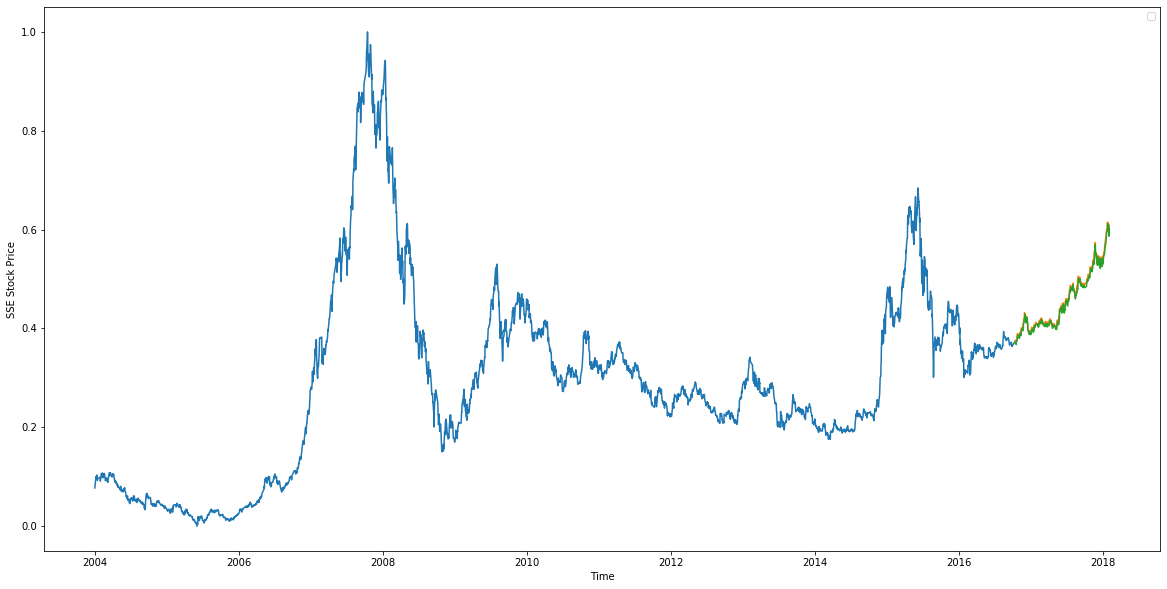

In [49]:
#for plotting
train = new_data[:3100]
valid = new_data[3100:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.xlabel('Time')
plt.ylabel('SSE Stock Price')
plt.legend()
plt.show()